In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is the second attempt to read in track information and use it to predict the KDE used as input to PvFinder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_C.py uses poca_z, poca_x, poca_y, major_axis_x, major_axis_y, and major_axis_z as the six track parameters (for the moment)


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sat Jan 30 16:26:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   33C    P8    23W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 150

folder = '30Jan_DDplus_loss_Ba_iter21_floatAll_150epochs_1p5em5_4xwill'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML_dir/' + folder
output = Path(folder)


# Size of batches
batch_size = 64 ## batch_size = 24 ---> 4763MiB / 12066MiB on Titan V
# How fast to learn
learning_rate = 1.5e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
from model.collectdata_kde_Ellipsoids import collect_t2kde_data

##  It takes 9 input features (poca centers + (A,B,C,D,E,F)) . 
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model

# kde_loss_Ba is a Chi2 loss (go and look at it!)
from model.kde_loss_Ba import Loss

from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
# either 0 or 2 on goofy (i.e. TITAN V) [1 or 2 on sleepy RTX 2080TI]
device = select_gpu(2)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        # fixing parameters
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-5, debug=False)
loss = Loss(epsilon=3e-5)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)

## finished at training cost = 1.46, validation cost = 1.50
##d_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
d_folder = '30Jan_DDplus_loss_Ba_iter21_floatAll_150epochs_1p5em5_4xwill'
d_name = d_folder
##  for 24Jan_DDplus_loss_Ba_iter17_floatAll_150epochs_1p5em5_4xwill use suffix 87
##  as this is the last epoch that ran before I killed the job (don't ask)
suffix = '42'
dict_name = 'ML_dir/' + d_folder + '/' + d_name + '_'+ suffix + '.pyt'
print('dict_name = ',dict_name)
pretrained_dict = torch.load(dict_name)

print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)



output =  ML_dir/30Jan_DDplus_loss_Ba_iter21_floatAll_150epochs_1p5em5_4xwill
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
index, k =   

<All keys matched successfully>

In [14]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [15]:
## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                                  '/share/lazy/will/data/June30_2020_80k_2.h5',
                                  '/share/lazy/will/data/June30_2020_80k_3.h5',
                                  '/share/lazy/will/data/June30_2020_80k_4.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                          device=device,
##                           slice = slice(None,18000)
                           )

Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  0.00045611936
majorAxis[iTrk][1][0] =  -4.8292455e-05
majorAxis[iTrk][2][0] =  0.090019904
minorAxis_1[iTrk][0][0] =  -1.8602173
minorAxis_1[iTrk][1][0] =  -17.569641
minorAxis_1[iTrk][2][0] =  4.7891795e-08
minorAxis_2[iTrk][0][0] =  -17.569414
minorAxis_2[iTrk][1][0] =  1.8601931
minorAxis_2[iTrk][2][0] =  0.0900199
  
majorAxis[iTrk][0][0] =  0.002360258
majorAxis[iTrk][1][0] =  -0.007426616
majorAxis[iTrk][2][

nEvts =  80000
len(pocaMx[0]) =  196
len(pocaMx[1]) =  35
len(pocaMx[2]) =  265
len(pocaMx[3]) =  128
len(pocaMx[4]) =  124
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 196
 iEvt, nTrks =  1 35
 iEvt, nTrks =  2 265
 iEvt, nTrks =  3 128
 iEvt, nTrks =  4 124
 iEvt, nTrks =  5 122
 iEvt, nTrks =  6 300
 iEvt, nTrks =  7 179
 iEvt, nTrks =  8 243
 iEvt, nTrks =  9 112
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  -2.440992e-05
majorAxis[iTrk][1][0] =  -0.00038087237
majorAxis[iTrk][2][0] =  0.08211532
minorAxis_1[iTrk][0][0] =  -17.631672
minorAxis_1[iTrk][1][0] =  1.130005
minorAxis_1[iTrk][2][0] =  4.7444193e-08
minorAxis_2[iTrk][0][0] =  1.1299927
minorAxis_2[iTrk][1][0] =  17.631481
minorAxis_2[iTrk][2][0] =  0.08211532
  
majorAxis[iTrk][0][0] =  -0.02277395
majorAxis[iTrk][1][0] =  0.0014473597
majorAxis[iTrk][2][0] =  0.6347583
minorAxis_1[iTrk][0][0] =  -

In [16]:
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,

## For iter12, change slice(18000,None) to slice(10000,None)
## First, we'll see if this changes the validation cost significantly
##  Second, we will see if this reduces the validation cost fluctuations
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
##                            device=device,
                            slice = slice(10000,None)
                           )

Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

<IPython.core.display.Javascript object>


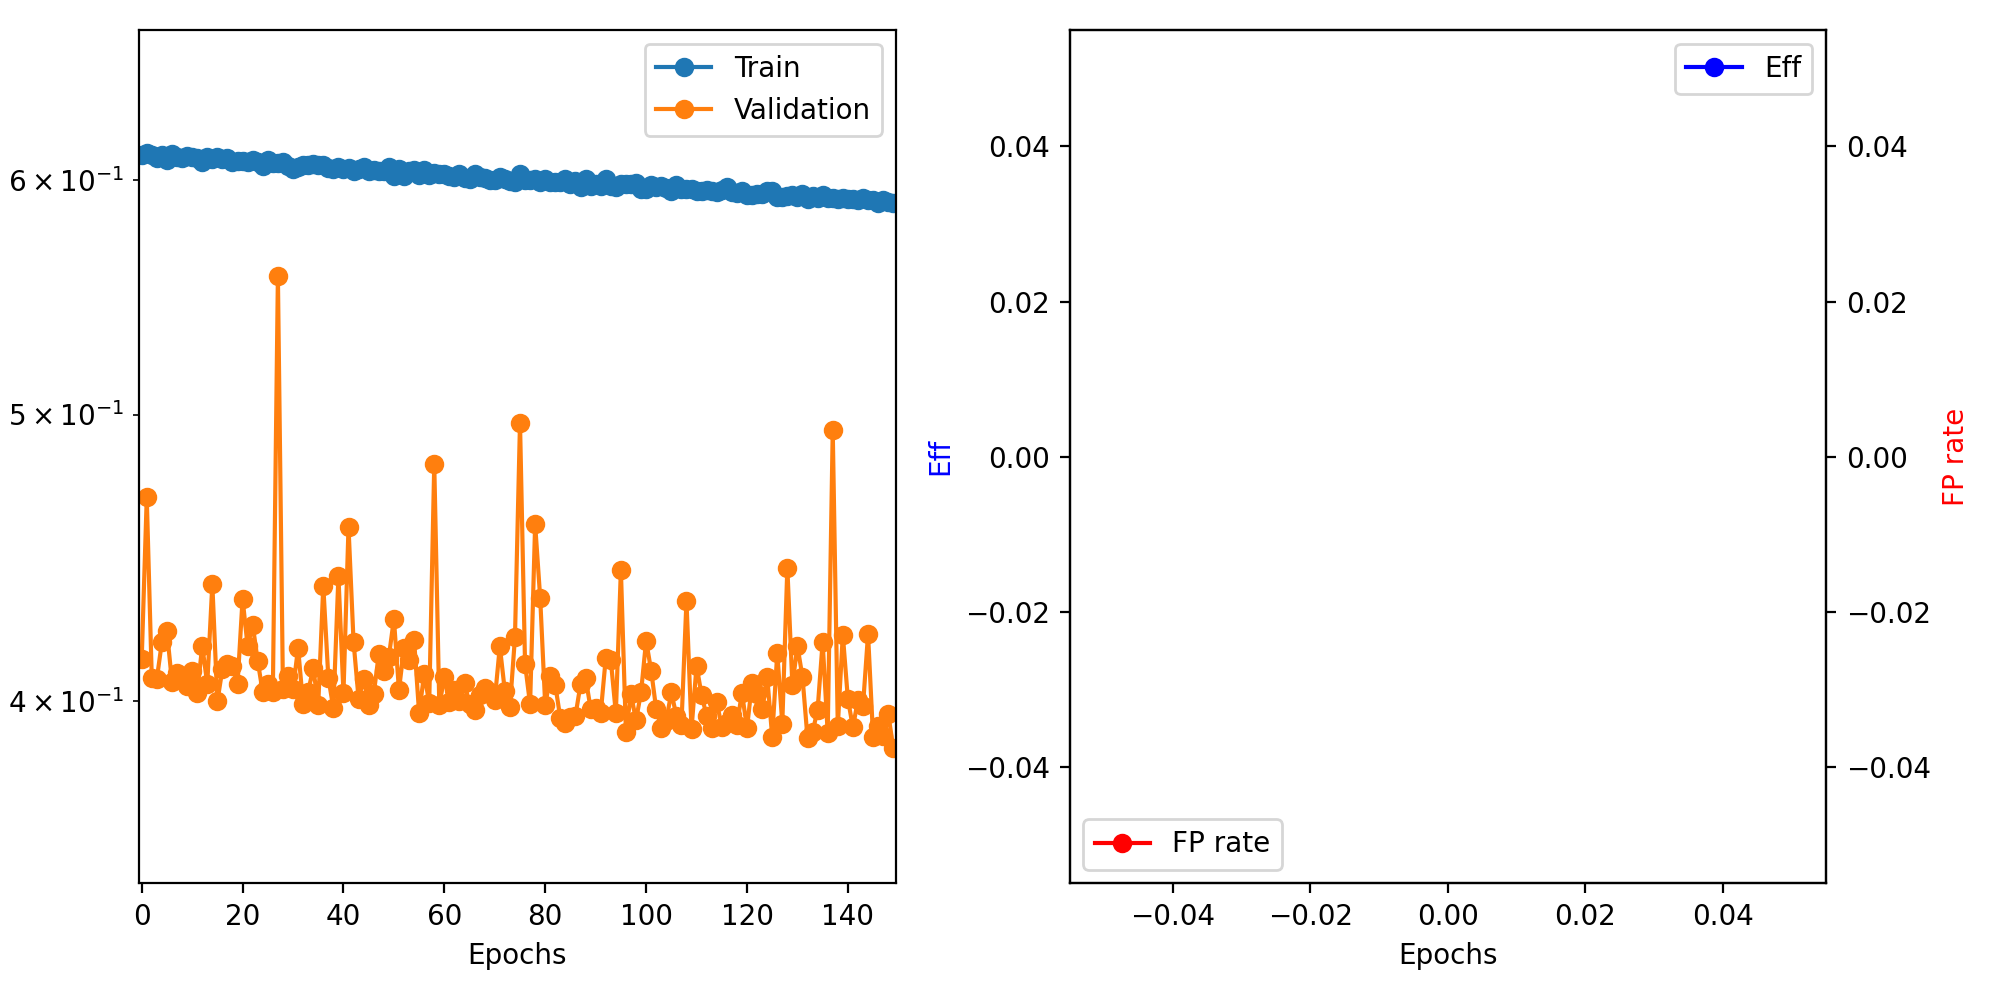

In [17]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [18]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 5000, val = 157


Number of batches: train = 5000, val = 157


Epoch 0: train=0.611854, val=0.413278, took 587.7 s


Epoch 1: train=0.613025, val=0.46879, took 590.83 s


Epoch 2: train=0.61168, val=0.407308, took 588.36 s


Epoch 3: train=0.610401, val=0.407116, took 586.88 s


Epoch 4: train=0.611954, val=0.418877, took 587.46 s


Epoch 5: train=0.609464, val=0.422481, took 587.59 s


Epoch 6: train=0.612388, val=0.406175, took 586.74 s


Epoch 7: train=0.610799, val=0.40903, took 586.33 s


Epoch 8: train=0.61044, val=0.406805, took 586.04 s


Epoch 9: train=0.611227, val=0.404792, took 587.64 s


Epoch 10: train=0.610715, val=0.409545, took 586.23 s


Epoch 11: train=0.610401, val=0.40268, took 586.43 s


Epoch 12: train=0.608705, val=0.417666, took 584.66 s


Epoch 13: train=0.610794, val=0.405436, took 586.09 s


Epoch 14: train=0.610144, val=0.438235, took 584.35 s


Epoch 15: train=0.610666, val=0.399997, took 585.21 s


Epoch 16: train=0.610052, val=0.410172, took 584.21 s


Epoch 17: train=0.610523, val=0.411883, took 585.5 s


Epoch 18: train=0.608647, val=0.411094, took 584.81 s


Epoch 19: train=0.608866, val=0.405489, took 584.51 s


Epoch 20: train=0.608964, val=0.433247, took 585.38 s


Epoch 21: train=0.608315, val=0.417497, took 585.24 s


Epoch 22: train=0.609562, val=0.424642, took 584.79 s


Epoch 23: train=0.608643, val=0.41278, took 584.54 s


Epoch 24: train=0.606578, val=0.402788, took 584.64 s


Epoch 25: train=0.609367, val=0.405303, took 584.52 s


Epoch 26: train=0.608148, val=0.402984, took 584.65 s


Epoch 27: train=0.60812, val=0.556839, took 585.06 s


Epoch 28: train=0.608687, val=0.403907, took 586.68 s


Epoch 29: train=0.606788, val=0.407877, took 583.94 s


Epoch 30: train=0.605286, val=0.403821, took 586.68 s


Epoch 31: train=0.606341, val=0.417015, took 585.83 s


Epoch 32: train=0.607062, val=0.39908, took 585.77 s


Epoch 33: train=0.607127, val=0.403097, took 584.56 s


Epoch 34: train=0.607568, val=0.410424, took 586.15 s


Epoch 35: train=0.607149, val=0.399036, took 585.26 s


Epoch 36: train=0.607335, val=0.437661, took 584.52 s


Epoch 37: train=0.605863, val=0.407472, took 585.27 s


Epoch 38: train=0.604991, val=0.397822, took 585.58 s


Epoch 39: train=0.606056, val=0.440968, took 587.05 s


Epoch 40: train=0.605054, val=0.402597, took 583.84 s


Epoch 41: train=0.605631, val=0.458124, took 584.75 s


Epoch 42: train=0.604061, val=0.418981, took 583.34 s


Epoch 43: train=0.605016, val=0.40079, took 582.99 s


Epoch 44: train=0.60596, val=0.407043, took 583.97 s


Epoch 45: train=0.604331, val=0.399035, took 583.95 s


Epoch 46: train=0.604709, val=0.402248, took 584.06 s


Epoch 47: train=0.604469, val=0.415049, took 585.15 s


Epoch 48: train=0.604505, val=0.409434, took 583.99 s


Epoch 49: train=0.606084, val=0.414192, took 585.08 s


Epoch 50: train=0.602101, val=0.426525, took 585.44 s


Epoch 51: train=0.605052, val=0.403579, took 584.37 s


Epoch 52: train=0.601772, val=0.416893, took 584.53 s


Epoch 53: train=0.604347, val=0.412937, took 585.56 s


Epoch 54: train=0.604554, val=0.419694, took 584.4 s


Epoch 55: train=0.602608, val=0.396261, took 584.14 s


Epoch 56: train=0.604815, val=0.408725, took 582.71 s


Epoch 57: train=0.602451, val=0.399489, took 583.97 s


Epoch 58: train=0.603153, val=0.48113, took 584.07 s


Epoch 59: train=0.602771, val=0.398794, took 585.37 s


Epoch 60: train=0.602917, val=0.407561, took 585.1 s


Epoch 61: train=0.602086, val=0.399924, took 584.8 s


Epoch 62: train=0.601571, val=0.403425, took 585.41 s


Epoch 63: train=0.602867, val=0.4, took 584.45 s


Epoch 64: train=0.601157, val=0.405801, took 585.69 s


Epoch 65: train=0.60064, val=0.399149, took 585.91 s


Epoch 66: train=0.602928, val=0.397356, took 584.83 s


Epoch 67: train=0.601327, val=0.402086, took 584.33 s


Epoch 68: train=0.601048, val=0.404243, took 584.67 s


Epoch 69: train=0.599834, val=0.402835, took 585.43 s


Epoch 70: train=0.599906, val=0.400493, took 583.87 s


Epoch 71: train=0.601248, val=0.417511, took 584.75 s


Epoch 72: train=0.600443, val=0.403176, took 585.84 s


Epoch 73: train=0.599704, val=0.398329, took 585.41 s


Epoch 74: train=0.59895, val=0.420406, took 585.0 s


Epoch 75: train=0.602732, val=0.496821, took 584.79 s


Epoch 76: train=0.600087, val=0.411822, took 583.55 s


Epoch 77: train=0.6001, val=0.399091, took 585.8 s


Epoch 78: train=0.600429, val=0.459075, took 585.67 s


Epoch 79: train=0.599242, val=0.433623, took 584.44 s


Epoch 80: train=0.600639, val=0.398796, took 585.82 s


Epoch 81: train=0.598956, val=0.407979, took 585.94 s


Epoch 82: train=0.599307, val=0.405029, took 583.83 s


Epoch 83: train=0.599155, val=0.3948, took 585.8 s


Epoch 84: train=0.600753, val=0.393432, took 584.39 s


Epoch 85: train=0.598311, val=0.395273, took 585.53 s


Epoch 86: train=0.599436, val=0.395614, took 584.0 s


Epoch 87: train=0.596999, val=0.405407, took 584.77 s


Epoch 88: train=0.600332, val=0.407451, took 584.69 s


Epoch 89: train=0.597274, val=0.397777, took 585.77 s


Epoch 90: train=0.598353, val=0.397823, took 584.97 s


Epoch 91: train=0.597274, val=0.396311, took 585.5 s


Epoch 92: train=0.600451, val=0.413709, took 586.0 s


Epoch 93: train=0.597203, val=0.413046, took 585.67 s


Epoch 94: train=0.59701, val=0.396348, took 585.12 s


Epoch 95: train=0.59816, val=0.443122, took 585.9 s


Epoch 96: train=0.598135, val=0.390451, took 585.67 s


Epoch 97: train=0.598088, val=0.402341, took 585.13 s


Epoch 98: train=0.598469, val=0.394164, took 585.5 s


Epoch 99: train=0.595862, val=0.402888, took 583.4 s


Epoch 100: train=0.596038, val=0.419365, took 585.81 s


Epoch 101: train=0.597858, val=0.409712, took 585.3 s


Epoch 102: train=0.596632, val=0.397634, took 585.14 s


Epoch 103: train=0.597287, val=0.391902, took 582.68 s


Epoch 104: train=0.59628, val=0.394079, took 585.79 s


Epoch 105: train=0.595122, val=0.402815, took 584.17 s


Epoch 106: train=0.597652, val=0.395631, took 585.7 s


Epoch 107: train=0.595912, val=0.392622, took 583.1 s


Epoch 108: train=0.595889, val=0.432597, took 585.27 s


Epoch 109: train=0.595789, val=0.391446, took 588.4 s


Epoch 110: train=0.594742, val=0.411258, took 585.7 s


Epoch 111: train=0.595166, val=0.402003, took 585.02 s


Epoch 112: train=0.595481, val=0.395484, took 585.88 s


Epoch 113: train=0.594728, val=0.391673, took 586.2 s


Epoch 114: train=0.594473, val=0.39987, took 585.21 s


Epoch 115: train=0.595426, val=0.392163, took 585.29 s


Epoch 116: train=0.596836, val=0.39335, took 584.96 s


Epoch 117: train=0.594358, val=0.395902, took 585.64 s


Epoch 118: train=0.594176, val=0.392624, took 584.56 s


Epoch 119: train=0.59476, val=0.402742, took 584.31 s


Epoch 120: train=0.593201, val=0.391766, took 584.43 s


Epoch 121: train=0.593089, val=0.405764, took 584.4 s


Epoch 122: train=0.593778, val=0.402387, took 583.57 s


Epoch 123: train=0.593548, val=0.397531, took 586.3 s


Epoch 124: train=0.594848, val=0.407809, took 584.39 s


Epoch 125: train=0.595139, val=0.389088, took 584.68 s


Epoch 126: train=0.592299, val=0.415426, took 584.75 s


Epoch 127: train=0.591978, val=0.393131, took 584.6 s


Epoch 128: train=0.592561, val=0.443884, took 585.97 s


Epoch 129: train=0.593274, val=0.405102, took 584.93 s


Epoch 130: train=0.592182, val=0.417598, took 586.5 s


Epoch 131: train=0.593759, val=0.40772, took 585.18 s


Epoch 132: train=0.591422, val=0.388734, took 584.26 s


Epoch 133: train=0.592647, val=0.390575, took 584.76 s


Epoch 134: train=0.591839, val=0.397398, took 584.84 s


Epoch 135: train=0.592956, val=0.418951, took 584.54 s


Epoch 136: train=0.591711, val=0.390254, took 584.36 s


Epoch 137: train=0.591813, val=0.493954, took 584.96 s


Epoch 138: train=0.591322, val=0.392347, took 586.18 s


Epoch 139: train=0.591737, val=0.42129, took 583.94 s


Epoch 140: train=0.591124, val=0.400793, took 584.38 s


Epoch 141: train=0.591271, val=0.392005, took 585.72 s


Epoch 142: train=0.590748, val=0.400522, took 585.49 s


Epoch 143: train=0.591553, val=0.398607, took 583.99 s


Epoch 144: train=0.59073, val=0.421532, took 584.35 s


Epoch 145: train=0.590634, val=0.389044, took 586.3 s


Epoch 146: train=0.58945, val=0.392326, took 585.17 s


Epoch 147: train=0.59092, val=0.38937, took 584.89 s


Epoch 148: train=0.589981, val=0.396255, took 585.12 s


Epoch 149: train=0.589212, val=0.38577, took 585.52 s



Go ahead and save the final model (even though it was also saved above):

In [19]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [20]:
results.to_hdf(output / f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


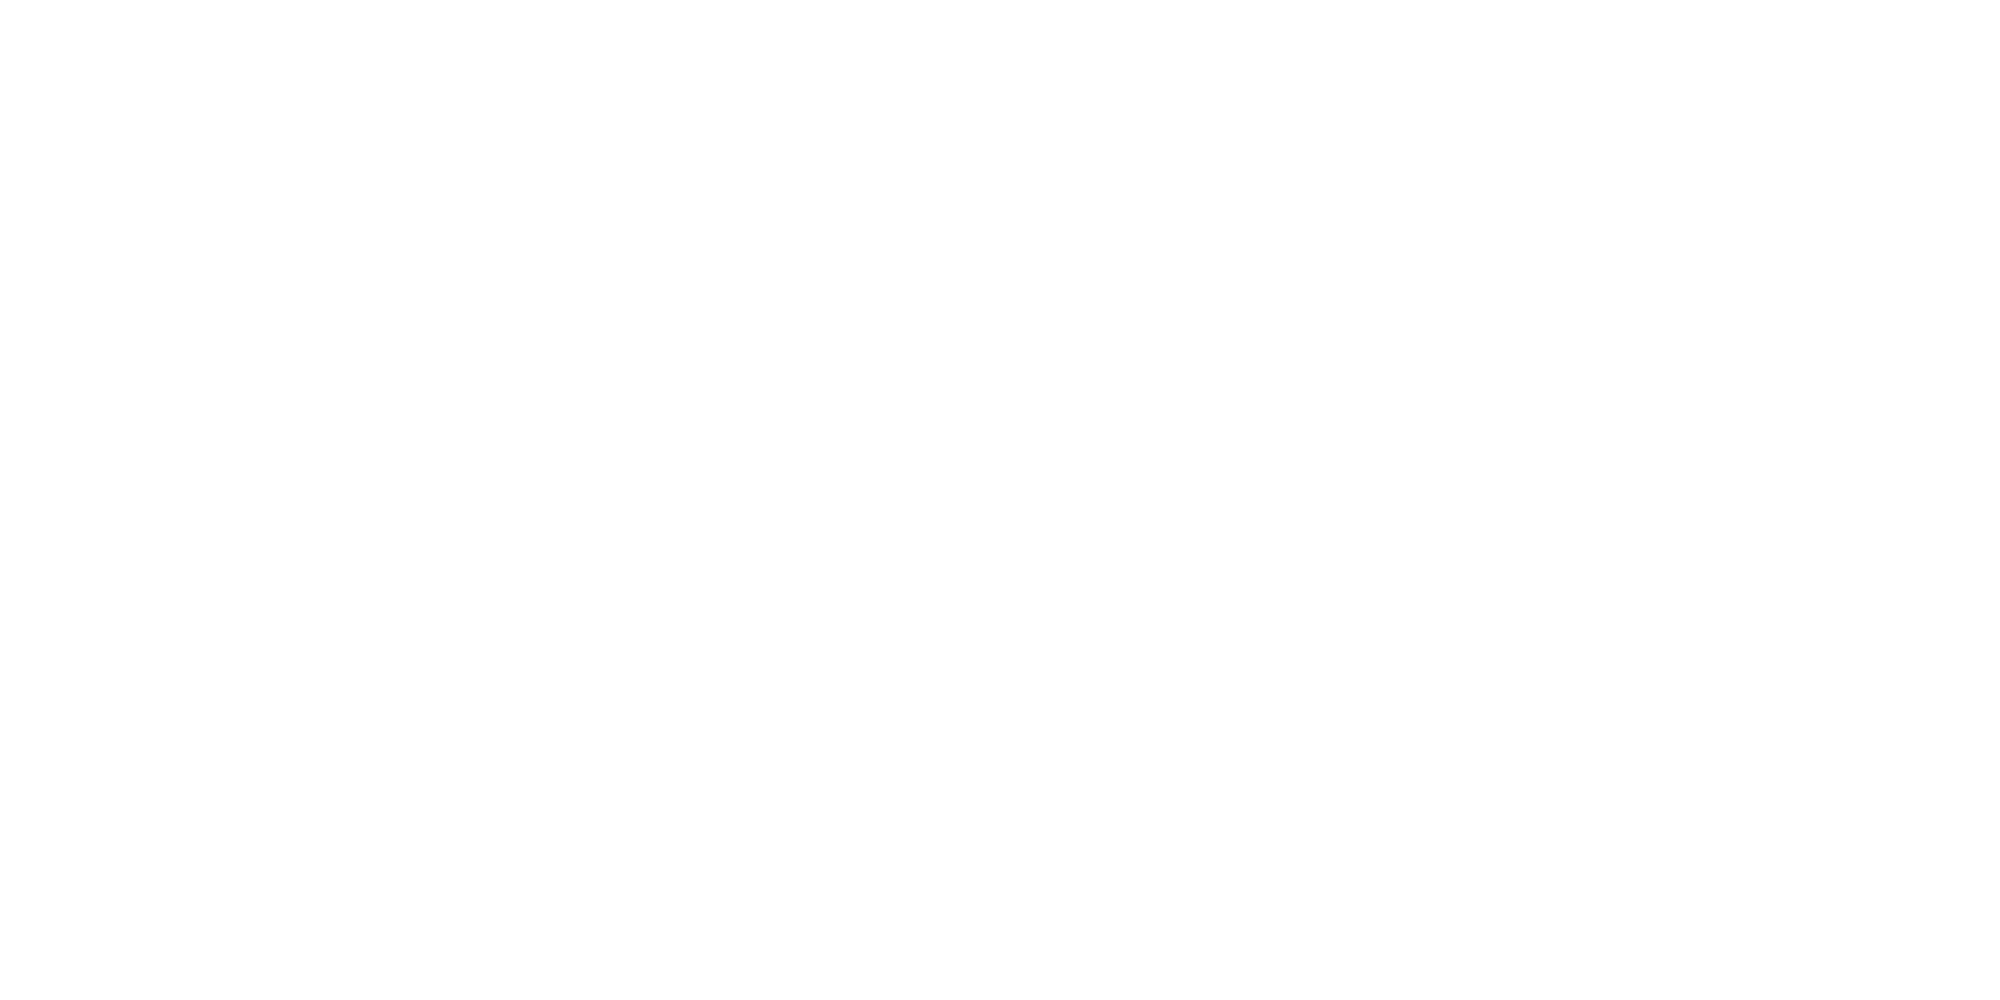

In [21]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [22]:
quit()